In [1]:
# pip install -u wetterdienst polars
from wetterdienst.provider.dwd.observation import DwdObservationRequest

# Übersicht aller Parameter
available_parameter = DwdObservationRequest.discover(resolutions = "hourly")

# Parameter anschauen
print(available_parameter)

{'hourly': {'cloud_type': [{'name': 'cloud_cover_total', 'name_original': 'v_n', 'unit_type': 'fraction', 'unit': 'one_eighth'}, {'name': 'cloud_cover_total_index', 'name_original': 'v_n_i', 'unit_type': 'dimensionless', 'unit': 'dimensionless'}, {'name': 'cloud_type_layer1', 'name_original': 'v_s1_cs', 'unit_type': 'dimensionless', 'unit': 'dimensionless'}, {'name': 'cloud_type_layer1_abbreviation', 'name_original': 'v_s1_csa', 'unit_type': 'dimensionless', 'unit': 'dimensionless'}, {'name': 'cloud_height_layer1', 'name_original': 'v_s1_hhs', 'unit_type': 'length_medium', 'unit': 'meter'}, {'name': 'cloud_cover_layer1', 'name_original': 'v_s1_ns', 'unit_type': 'fraction', 'unit': 'one_eighth'}, {'name': 'cloud_type_layer2', 'name_original': 'v_s2_cs', 'unit_type': 'dimensionless', 'unit': 'dimensionless'}, {'name': 'cloud_type_layer2_abbreviation', 'name_original': 'v_s2_csa', 'unit_type': 'dimensionless', 'unit': 'dimensionless'}, {'name': 'cloud_height_layer2', 'name_original': 'v_s

In [ ]:


# 1) Parameter auswählen ---
# Tageswerte ("daily") für Klimazusammenfassung, Niederschlag
parameters = ("daily", "climate_summary", "temperature_air_mean_2m")

# 2) Anfrage senden
req = DwdObservationRequest(
    parameters=parameters,
    start_date="2023-01-01",
    end_date="2025-01-10"
)

# 3) Station auswählen: "Freiburg" - https://www.dwd.de/DE/leistungen/klimadatenweltweit/stationsverzeichnis.html
stations = req.filter_by_station_id(station_id=("01048",))

# 4) Messwerte laden ---
# Wir nehmen die erste Station
first_values = next(stations.values.query())
temp_freiburg = first_values.df

# 5) Renaming columns, delete column quality

temp_freiburg = temp_freiburg.rename({
    "value": "celcius",
    "date": "datetime"
})

temp_freiburg = temp_freiburg.drop("quality")

# 6) Daten anzeigen lassen
print(temp_freiburg.head())

shape: (5, 6)
┌────────────┬────────────┬─────────────────┬──────────────────────┬─────────────────────┬─────────┐
│ station_id ┆ resolution ┆ dataset         ┆ parameter            ┆ datetime            ┆ celcius │
│ ---        ┆ ---        ┆ ---             ┆ ---                  ┆ ---                 ┆ ---     │
│ str        ┆ str        ┆ str             ┆ str                  ┆ datetime[μs, UTC]   ┆ f64     │
╞════════════╪════════════╪═════════════════╪══════════════════════╪═════════════════════╪═════════╡
│ 01048      ┆ daily      ┆ climate_summary ┆ temperature_air_mean ┆ 2023-01-01 00:00:00 ┆ 15.1    │
│            ┆            ┆                 ┆ _2m                  ┆ UTC                 ┆         │
│ 01048      ┆ daily      ┆ climate_summary ┆ temperature_air_mean ┆ 2023-01-02 00:00:00 ┆ 12.4    │
│            ┆            ┆                 ┆ _2m                  ┆ UTC                 ┆         │
│ 01048      ┆ daily      ┆ climate_summary ┆ temperature_air_mean ┆ 2023-01-

In [13]:
# Heizgradtage berechnen

print(temp_freiburg.describe())

shape: (9, 7)
┌────────────┬────────────┬────────────┬───────────────┬───────────────┬───────────────┬───────────┐
│ statistic  ┆ station_id ┆ resolution ┆ dataset       ┆ parameter     ┆ datetime      ┆ celcius   │
│ ---        ┆ ---        ┆ ---        ┆ ---           ┆ ---           ┆ ---           ┆ ---       │
│ str        ┆ str        ┆ str        ┆ str           ┆ str           ┆ str           ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════╡
│ count      ┆ 741        ┆ 741        ┆ 741           ┆ 741           ┆ 741           ┆ 741.0     │
│ null_count ┆ 0          ┆ 0          ┆ 0             ┆ 0             ┆ 0             ┆ 0.0       │
│ mean       ┆ null       ┆ null       ┆ null          ┆ null          ┆ 2024-01-06    ┆ 11.378947 │
│            ┆            ┆            ┆               ┆               ┆ 00:00:00+00:0 ┆           │
│            ┆            ┆            ┆               ┆               ┆ 0   

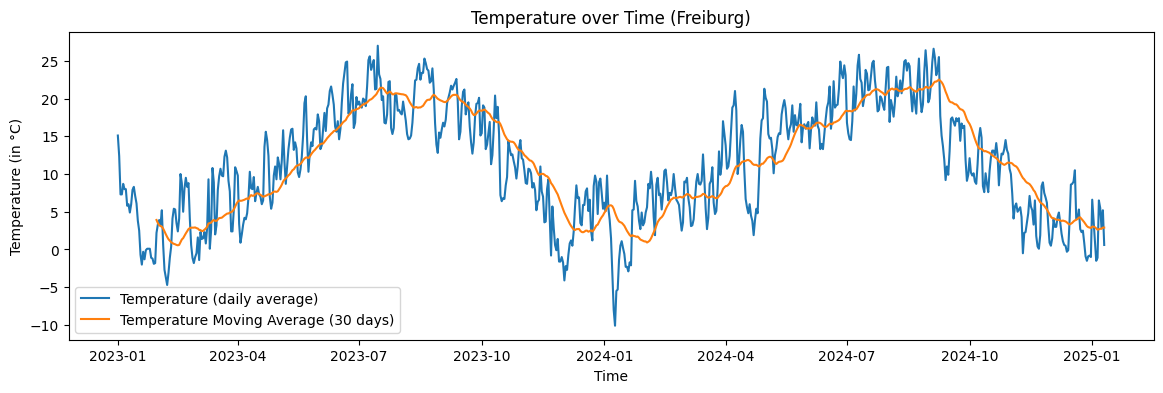

In [59]:
# Diagramm: Temperature over time (Freiburg)

import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

# Transforming temp_freiburg in DataFrame
temp_freiburg = pd.DataFrame(temp_freiburg)

# calculating moving average 
temp_freiburg["ma_temp"] = temp_freiburg["celcius"].rolling(window=30).mean()

# Plot
plt.figure(figsize=(14,4))
sb.lineplot(data=temp_freiburg, x="datetime", y="celcius", label="Temperature (daily average)")
sb.lineplot(data=temp_freiburg, x="datetime", y="ma_temp", label="Temperature Moving Average (30 days)")
plt.title("Temperature over Time (Freiburg)")
plt.xlabel("Time")
plt.ylabel("Temperature (in °C)")
plt.show()





In [ ]:
import os

# Ordner für CSV erstellen
folder = "dwd data"
os.makedirs(folder, exist_ok=True)

# Dateipfad definieren
file_path = os.path.join(folder, "freiburg_hourly_temp_2023-01-01_to_2023-06-30.csv")

# CSV speichern
temp_freiburg.write_csv(file_path)

print(f"CSV gespeichert unter: {file_path}")


CSV gespeichert unter: dwd data\freiburg_hourly_temp_2023-01-01_to_2023-06-30.csv
